# ELECTRA Multi-lingual Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the multi-lingual language set coming from `Datasets/ELECTRA/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [1]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
!pip install -q keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import keras_tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
import tensorflow
import os
import sklearn.metrics

keras.mixed_precision.set_global_policy("mixed_float16")

label_names = ["entailment", "neutral", "contradiction"]

<ipython-input-4-c0f7e6a58d6c>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


#### Data Exploration and Visualization

In [5]:
electra_multi_dataset = pandas.read_csv("train_all_languages.csv")

electra_multi_dataset["premise"] = electra_multi_dataset["premise"].apply(lambda x: x.lower())

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].apply(lambda x: x.lower())

spec_char_regex = r"[.!?,:;\"{}\[\]\(\)\~<>|\\/+*/@#$%^]+"
electra_multi_dataset["premise"] = electra_multi_dataset["premise"].replace(to_replace=spec_char_regex, value="", regex=True)

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].replace(to_replace=spec_char_regex, value="", regex=True)

numbers_regex = r"[0-9]+"
electra_multi_dataset["premise"] = electra_multi_dataset["premise"].replace(to_replace=numbers_regex, value="", regex=True)

electra_multi_dataset["hypothesis"] = electra_multi_dataset["hypothesis"].replace(to_replace=numbers_regex, value="", regex=True)

electra_multi_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,English,2,contradiction
1,1,3931fbe82a,des petites choses comme celles-là font une di...,j'essayais d'accomplir quelque chose,fr,French,0,entailment
2,2,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,neutral
3,3,ed7d6a1e62,bir çiftlikte birisinin ağıla kapatılmış bu ök...,çiftlikte insanlar farklı terimler kullanırlar,tr,Turkish,0,entailment
4,4,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0,entailment


##### Validation to ensure the data is clean when being passed to the model

In [6]:
electra_multi_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [7]:
electra_multi_dataset.label[~electra_multi_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [8]:
electra_multi_dataset.id.count()

6060

- A fairly small dataset relatively speaking to other sources.

In [9]:
electra_multi_dataset.hypothesis.describe()

,hypothesis
count,6060
unique,6059
top,bettelheim killed himself in
freq,2


In [10]:
for i in range(10):
    print(electra_multi_dataset.hypothesis[i])

practice groups are not permitted to work on these issues
j'essayais d'accomplir quelque chose
เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร
çiftlikte insanlar farklı terimler kullanırlar
ہیگ کی تفتیش ایف بی آئی اہلکاروں  کی طرف سے کی گئی
from st ann's bay to cockpit country
краска изменяется в соответствии с цветом
könnte das interesse mehr als  sein
大人刚刚接受了我的意见，并且采取了相应的行动。
watoto wangeweza kwenda kwa majirani zao nyumba


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [11]:
electra_multi_dataset.premise.describe()

,premise
count,6060
unique,4943
top,also in eustace street is an information offic...
freq,3


In [12]:
for i in range(10):
    print(electra_multi_dataset.premise[i])

these are issues that we wrestle with in practice groups of law firms she said 
des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire
ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
bir çiftlikte birisinin ağıla kapatılmış bu öküzleri kesmeliyiz dediğini duyabilirsiniz bu muhtemelen şu anlama gelir yüklenecek olanları ayırın
ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی آئی کے ایجنٹوں کے ذریعے ہوائی اڈے پر ملاقات کی، تحقیقات کی، اور اگلے دن وفاقی گرین جوری سے پہلے اسامہ بن لادن کی تحقیقات سے ملاقات کی
from cockpit country to st ann's bay
через каждые сто градусов пятна краски меняют свой цвет она может быть красной и изменить цвет на синий
es fallen zwanzig prozent zinsen an
我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
watoto wangegonga milango ya majirani zao na


- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [13]:
electra_multi_dataset.label.describe()

,label
count,6060.000000
mean,0.996865
std,0.827500
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

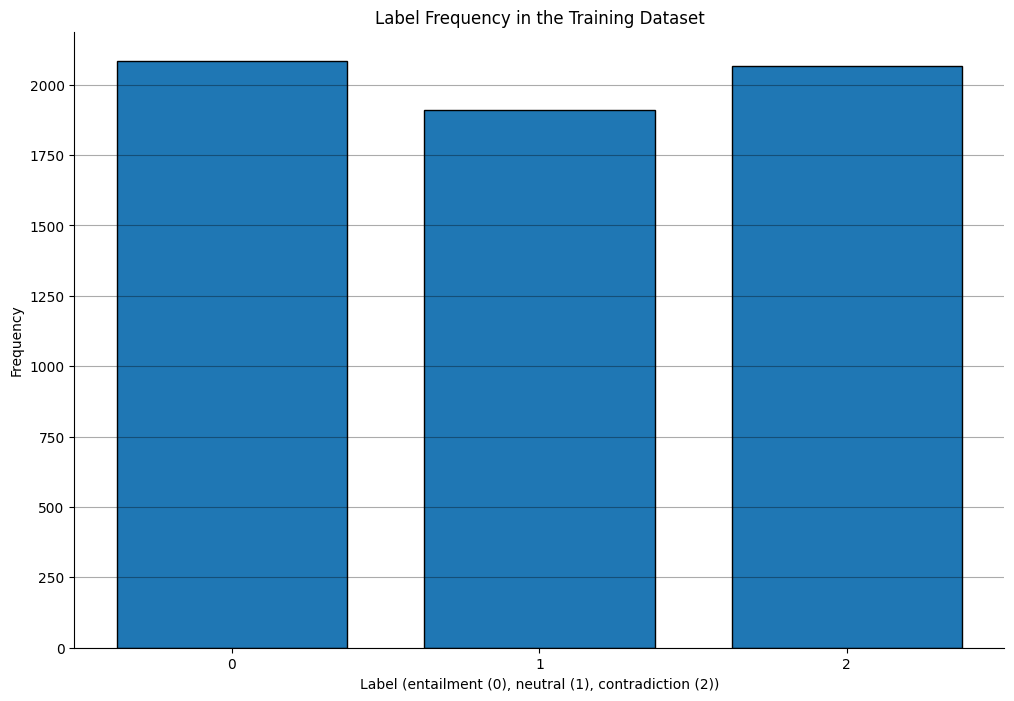

In [14]:
labels = electra_multi_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [15]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = electra_multi_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = electra_multi_dataset.premise.apply(get_length_of_text)

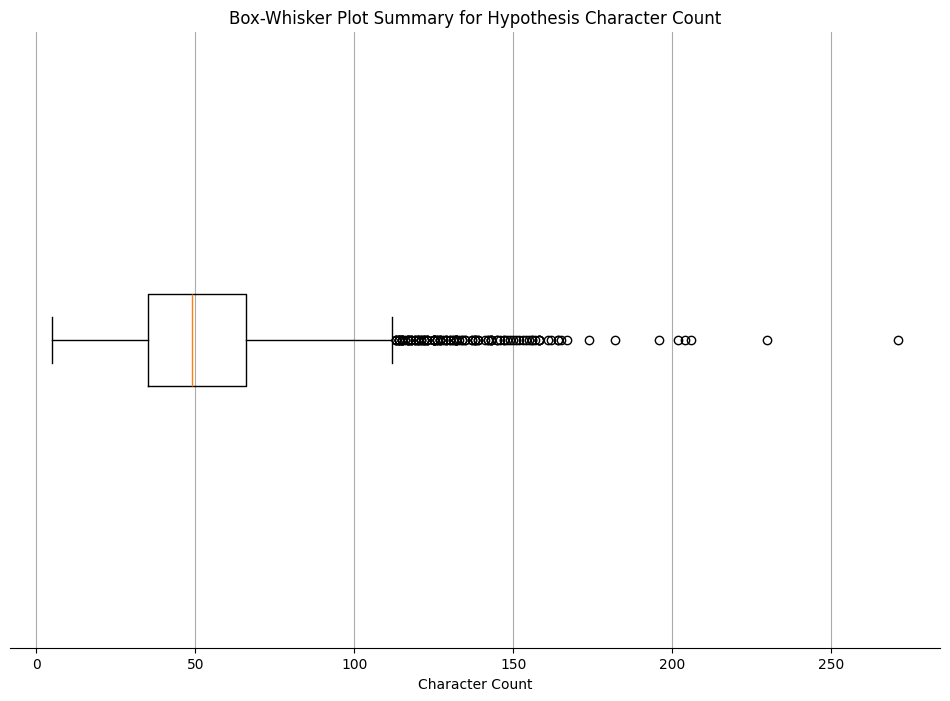

In [16]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

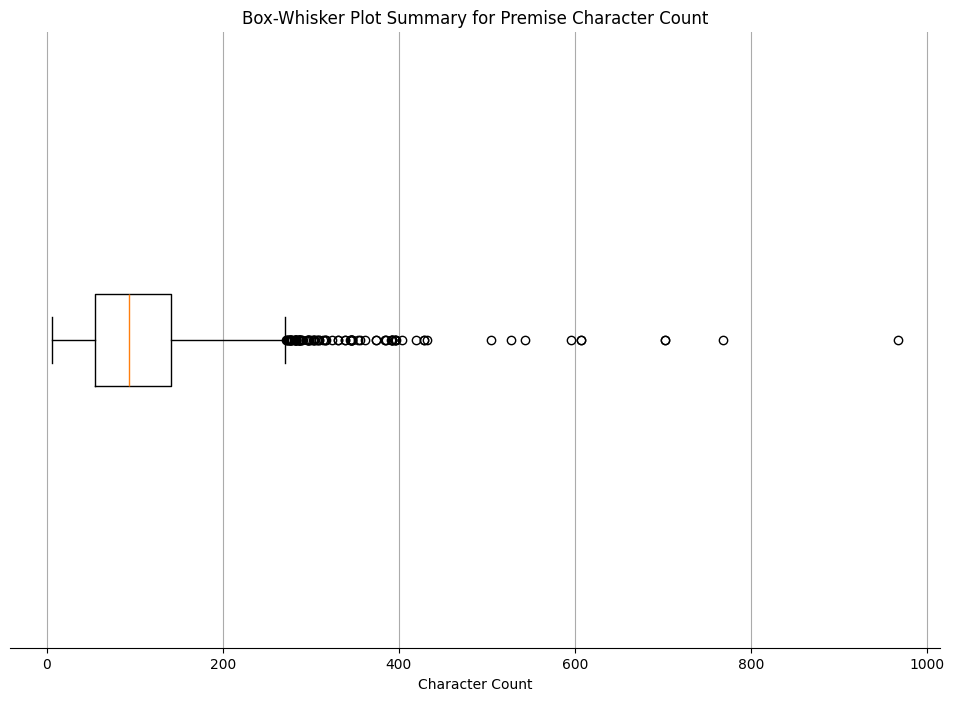

In [17]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [33]:
def split_labels(x, y):
    return (x[0], x[1]), y

def process_labels_and_predictions(datalist, logits):
    predictions = tensorflow.argmax(tensorflow.nn.softmax(logits, 1), 1).numpy()

    first_label_set_processed = False

    labels = None

    for i in range(len(datalist)):
        if not first_label_set_processed:
            labels = datalist[i][1].numpy()

            first_label_set_processed = True
        else:
            labels = numpy.hstack((labels, datalist[i][1].numpy()))

    return labels, predictions


def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)


def plot_model_result(_losses, _accuracies, batch_size, _is_training=True):
    plt.style.use('seaborn-v0_8-dark')

    fig, (momentum_loss_ax, momentum_acc_ax) = plt.subplots(1, 2, figsize=(16,6))
    momentum_loss_ax.plot(numpy.arange(1, len(_losses) + 1), _losses)
    momentum_loss_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_loss_ax.set_xticks(numpy.arange(1, len(_losses) + 1))
    momentum_loss_ax.set_ylabel("CCE loss")
    momentum_loss_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Loss for ELECTRA Multi")
    momentum_loss_ax.grid()

    momentum_acc_ax.plot(numpy.arange(1, len(_accuracies) + 1), _accuracies)
    momentum_acc_ax.set_xlabel(f"Epoch (Batch size = {batch_size})")
    momentum_acc_ax.set_xticks(numpy.arange(1, len(_accuracies) + 1))
    momentum_acc_ax.set_ylabel("Accuracy (%)")
    momentum_acc_ax.set_yticks(numpy.arange(0, 1.1, .1))
    momentum_acc_ax.set_title(f"{'Training' if _is_training else 'Validation'} Epoch vs. Accuracy for ELECTRA Multi")
    momentum_acc_ax.grid()

    plt.show()

def plot_metrics(model):
    # predict on the validation set
    validation_logits = model.predict(val_set)

    validation_set_list = list(val_set)

    labels, predictions = process_labels_and_predictions(validation_set_list, validation_logits)

    # classification report
    print(sklearn.metrics.classification_report(labels, predictions, target_names=label_names))

    # plot the confusion matrix
    matrix = sklearn.metrics.ConfusionMatrixDisplay(
        sklearn.metrics.confusion_matrix(labels, predictions),
        display_labels=label_names
    )
    matrix.plot()
    plt.show()


In [34]:
VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(electra_multi_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            electra_multi_dataset[["hypothesis", "premise"]].values,
            electra_multi_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

batch_size = 32

num_epochs = 5

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).cache().shuffle(buffer_size=batch_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)

In [45]:
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_base_discriminator_uncased_en")
bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=240)
train_set = (
    train_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

val_set = (
    val_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

electra_discriminator_back = keras_nlp.models.Backbone.from_preset("electra_base_discriminator_uncased_en")
bert_classifier = keras_nlp.models.BertClassifier(electra_discriminator_back, 3, preprocessor=None)


- ***Run this cell if training can be skipped***

In [42]:
bert_classifier.load_weights("/content/drive/MyDrive/model weights/ELECTRA_Multi.weights.h5")


- ***Run this cell if a new model should be made***

Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 163ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.3587 - val_loss: 0.9431 - val_sparse_categorical_accuracy: 0.5059
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - loss: 0.9266 - sparse_categorical_accuracy: 0.5303 - val_loss: 0.8429 - val_sparse_categorical_accuracy: 0.6030
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.7380 - sparse_categorical_accuracy: 0.6229 - val_loss: 0.9340 - val_sparse_categorical_accuracy: 0.5887
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.6956 - val_loss: 1.0665 - val_sparse_categorical_accuracy: 0.5693
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.5466 - sparse_categorical_accuracy: 0.7128 - val_loss: 1.0282 - val_sparse_categorical_accuracy: 0.5895


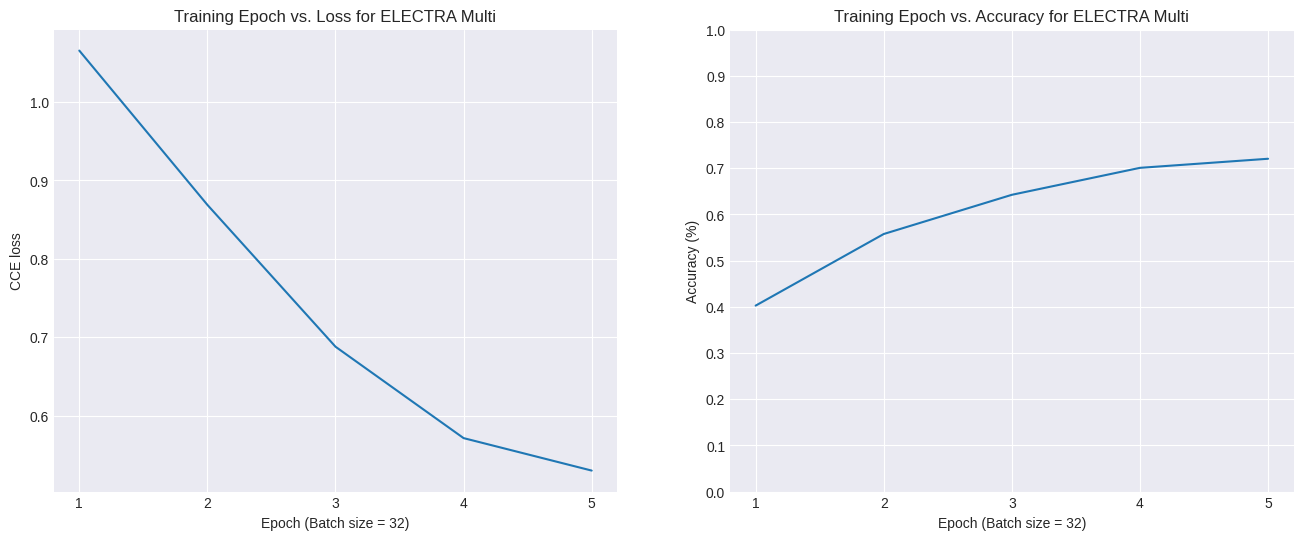

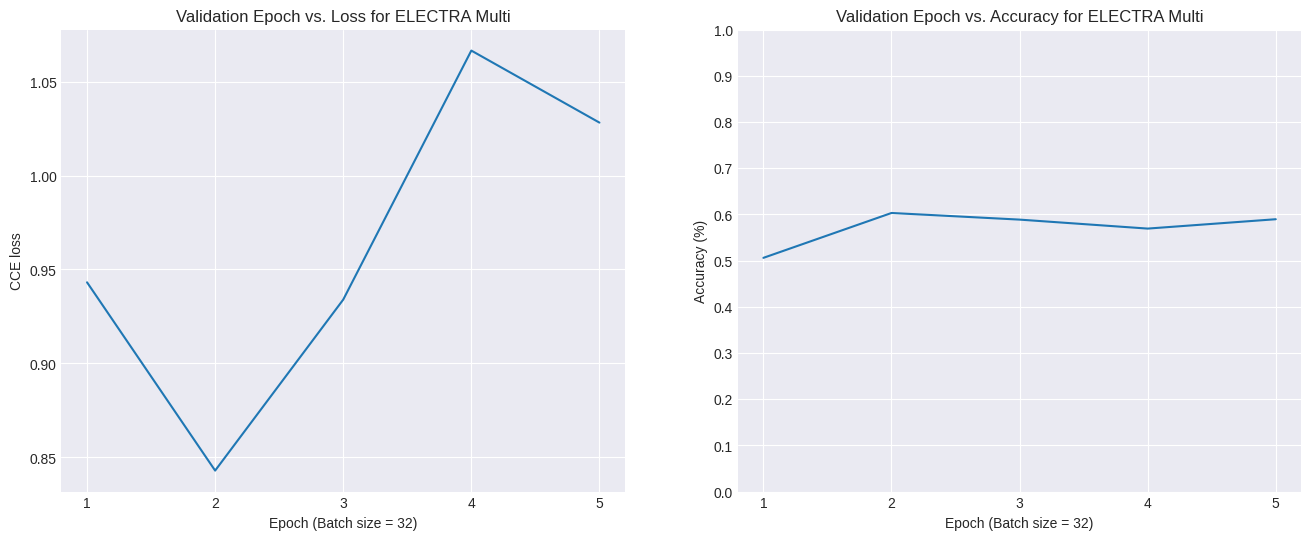

In [36]:
classifier_history = bert_classifier.fit(train_set, epochs=5, validation_data=val_set)
training_losses = classifier_history.history["loss"]

training_accuracies = classifier_history.history["sparse_categorical_accuracy"]

validation_losses = classifier_history.history["val_loss"]

validation_accuracies = classifier_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies, batch_size)

plot_model_result(validation_losses, validation_accuracies, batch_size, False)

#### Optimizer and Loss selection will remain set to the defaults of the preset

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
               precision    recall  f1-score   support

   entailment       0.67      0.59      0.63       396
      neutral       0.73      0.32      0.44       372
contradiction       0.51      0.83      0.63       416

     accuracy                           0.59      1184
    macro avg       0.64      0.58      0.57      1184
 weighted avg       0.63      0.59      0.57      1184



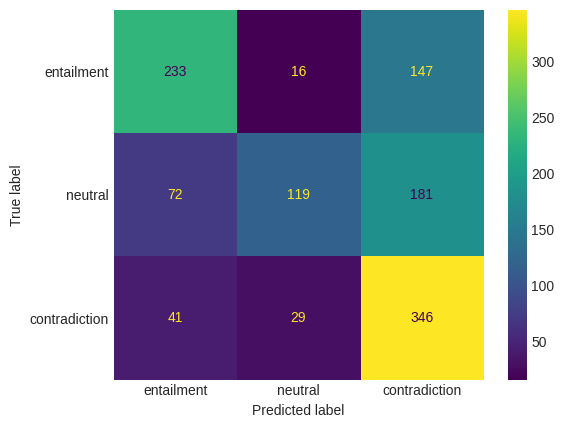

None


In [37]:
print(plot_metrics(bert_classifier))

#### Saving the Model

In [41]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
bert_classifier.save_weights("/content/drive/MyDrive/model weights/ELECTRA_Multi.weights.h5")


# Hyperparameter Search

## Given we have been using keras for our model, we use keras tuner for the hyperparameter search. We wrap our model creation logic inside of a class to be able to use it in keras tuner.

- ***Run this cell if hyperparameter seaching can be skipped***

In [ ]:
final_model = bert_classifier
final_model.load_weights("/content/drive/MyDrive/model weights/Tuned_ELECTRA_Multi.weights.h5")


- ***Run the below cells to start a new hyperparameter search***

In [23]:
class ElectraHyperModel(HyperModel):
    def __init__(self, backbone, num_classes, preprocessor):
        self.backbone = backbone
        self.num_classes = num_classes
        self.preprocessor = preprocessor

    def build(self, hp):
        # hyperparameters to tune
        learning_rate = hp.Float("learning_rate",
                                  min_value=1e-5,
                                  max_value=1e-3,
                                  sampling="log")

        dropout_rate = hp.Float("dropout_rate",
                                min_value=0.1,
                                max_value=0.5,
                                step=0.1)

        # build the model + dropout
        classifier = keras_nlp.models.BertClassifier(
            backbone=self.backbone,
            num_classes=self.num_classes,
            preprocessor=self.preprocessor,
            dropout = dropout_rate
        )

        return classifier


In [24]:
# initalize tokenizer and backbone as before
# electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_discriminator_uncased_en")
# bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(
#     electra_discriminator_token,
#     sequence_length=240
# )

electra_discriminator_back = keras_nlp.models.Backbone.from_preset(
    "electra_small_discriminator_uncased_en"
)

# define the hypermodel
hypermodel = ElectraHyperModel(
    backbone=electra_discriminator_back,
    num_classes=3,
    preprocessor=None  # Since you're handling preprocessing separately
)

# initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective="val_sparse_categorical_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="kt_electra",
    project_name="electra_hyperparameter_tuning"
)

100%|██████████| 545/545 [00:00<00:00, 771kB/s]


100%|██████████| 52.1M/52.1M [00:01<00:00, 48.8MB/s]


In [25]:
# define early stopping
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# run the search
tuner.search(
    train_set,
    epochs=5,  # may stop earlier
    validation_data=val_set,
    callbacks=[stop_early]
)

Trial 5 Complete [00h 01m 38s]
val_sparse_categorical_accuracy: 0.53125

Best val_sparse_categorical_accuracy So Far: 0.5329391956329346
Total elapsed time: 00h 08m 25s


In [26]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')},
the optimal dropout rate is {best_hps.get('dropout_rate')}
""")


The optimal learning rate is 2.126640040997559e-05,
the optimal dropout rate is 0.4



In [27]:
# build the model with the best hyperparameters
final_model = hypermodel.build(best_hps)

# train the final model
final_history = final_model.fit(
    train_set,
    epochs=5,
    validation_data=val_set,
    callbacks=[stop_early]
)

# eval the model
final_loss, final_accuracy = final_model.evaluate(val_set)
print(f"Final Validation Loss: {final_loss}")
print(f"Final Validation Accuracy: {final_accuracy}")

Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - loss: 0.6779 - sparse_categorical_accuracy: 0.8137 - val_loss: 1.2689 - val_sparse_categorical_accuracy: 0.5389
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.3381 - sparse_categorical_accuracy: 0.8724 - val_loss: 1.3819 - val_sparse_categorical_accuracy: 0.5287
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.8882 - val_loss: 1.4961 - val_sparse_categorical_accuracy: 0.5296
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.2565 - sparse_categorical_accuracy: 0.8902 - val_loss: 1.5361 - val_sparse_categorical_accuracy: 0.5346
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6204 - sparse_categorical_accuracy: 0.5222
Final Validation Loss: 1.5360796451568604
Final Validation Accuracy: 0.5346283912658691


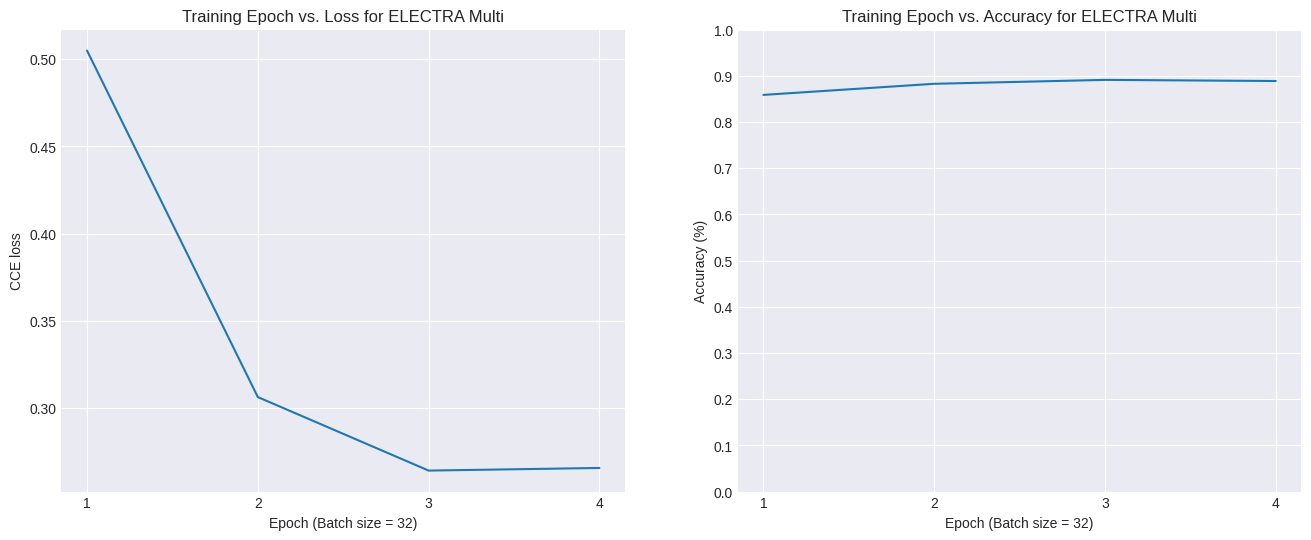

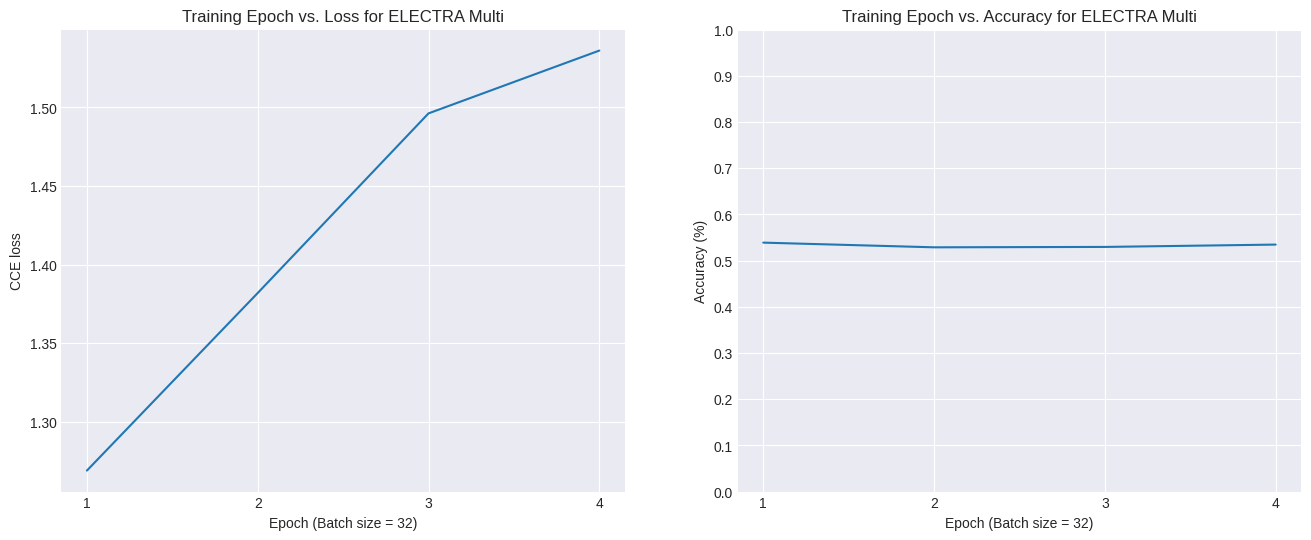

In [28]:
# plot training history
training_losses = final_history.history["loss"]
training_accuracies = final_history.history["sparse_categorical_accuracy"]
validation_losses = final_history.history["val_loss"]
validation_accuracies = final_history.history["val_sparse_categorical_accuracy"]

plot_model_result(training_losses, training_accuracies, batch_size)
plot_model_result(validation_losses, validation_accuracies, batch_size)

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
               precision    recall  f1-score   support

   entailment       0.53      0.58      0.56       396
      neutral       0.50      0.47      0.48       372
contradiction       0.57      0.55      0.56       416

     accuracy                           0.53      1184
    macro avg       0.53      0.53      0.53      1184
 weighted avg       0.53      0.53      0.53      1184



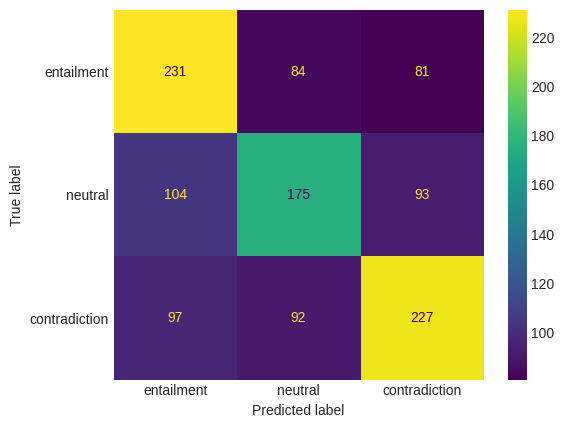

None


In [29]:
print(plot_metrics(final_model))

In [32]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
final_model.save_weights("/content/drive/MyDrive/model weights/Tuned_ELECTRA_Multi.weights.h5")
